# LDA

## Set up

In [1]:
data_in = './data_in/'
data_out = './data_out/'
data_prefix = 'zapatistas'

In [8]:
OHCO = ['text_id', 'section_num', 'para_num']
TEXT = OHCO[:1]
SECTION = OHCO[:2]
PARA = OHCO[:3]
BAG = PARA

In [3]:
import pandas as pd

In [37]:
TOKENS = pd.read_csv('{}/{}-TOKEN.csv'.format(data_in, data_prefix))
LIB = pd.read_csv("{}/{}-LIB.csv".format(data_in, data_prefix)).set_index('text_id')
LABELS = ['text_title'] # These are from the LIB table

In [39]:
TOKENS.term_str = TOKENS.term_str.fillna('')

In [40]:
TOKENS

,text_id,section_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str
0,1,1,0,0,0,"('[The', 'JJ')",JJ,[The,the
1,1,1,0,0,1,"('Mexican', 'NNP')",NNP,Mexican,mexican
2,1,1,0,0,2,"('Awakener', 'NNP')",NNP,Awakener,awakener
3,1,1,0,0,3,"('[El', 'NNP')",NNP,[El,el
4,1,1,0,0,4,"('Despertador', 'NNP')",NNP,Despertador,despertador
...,...,...,...,...,...,...,...,...,...
132444,9,8,13,2,3,"('if', 'IN')",IN,if,if
132445,9,8,13,2,4,"('you', 'PRP')",PRP,you,you
132446,9,8,13,2,5,"('can.', 'VBP')",VBP,can.,can
132447,9,8,13,3,0,"('All', 'DT')",DT,All,all


In [10]:
import pandas as pd # Put here again in case we copy into a separate file
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

class TopicExplorer:
    
    n_features = 4000
    stopwords = 'english'
    lda_num_topics = 40
    lda_max_iter = 5
    lda_n_top_terms = 10
    
    def __init__(self, tokens_df, lib_df, bag, labels=[]):
        self.TOKENS = tokens_df
        self.LIB = lib_df
        self.bag = bag
        self.labels = labels
        
    def generate_tables(self):
        print("BAG:", self.bag[-1])
        print("LABELS:", self.labels)
        print("Getting DOCS")
        self._get_docs()
        print("Getting TERMS")
        self._get_count_model()
        print("Getting THETA, PHI")
        self._get_topic_model()
        print("Getting TOPICS")
        self._get_topics()
        print('Binding LIB labels to THETA')
        self._bind_labels()
        print("Done.")
        return self
        
    def _get_docs(self, pos_remove_pat=r'^NNS?$'):
        self.DOCS = self.TOKENS[self.TOKENS.pos.str.match(pos_remove_pat)]\
            .groupby(self.bag).term_str\
            .apply(lambda x: ' '.join(x))\
            .to_frame()\
            .rename(columns={'term_str':'doc_str'})
        
    def _get_count_model(self):
        self.count_engine = CountVectorizer(max_features=self.n_features, 
                                            stop_words=self.stopwords)
        self.count_model = self.count_engine.fit_transform(self.DOCS.doc_str)
        self.TERMS = self.count_engine.get_feature_names()
        
    def _get_topic_model(self):
        self.lda_engine = LDA(n_components=self.lda_num_topics, 
                              max_iter=self.lda_max_iter, 
                              learning_offset=50., 
                              random_state=0)
        self.THETA = pd.DataFrame(self.lda_engine.fit_transform(self.count_model), 
                                  index=self.DOCS.index)
        self.THETA.columns.name = 'topic_id'
        self.PHI = pd.DataFrame(self.lda_engine.components_, columns=self.TERMS)
        self.PHI.index.name = 'topic_id'
        self.PHI.columns.name = 'term_str'
        
    def _get_topics(self, n_terms=10):
        self.TOPICS = self.PHI.stack().to_frame('weight')\
            .groupby('topic_id')\
            .apply(lambda x: x.weight.sort_values(ascending=False)\
               .head(self.lda_n_top_terms)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)
        self.TOPICS['label'] = self.TOPICS[[t for t in range(self.lda_n_top_terms)]]\
            .apply(lambda x: str(x.name).zfill(len(str(self.lda_num_topics))) + ' ' + ' '.join(x), 1)
        self.TOPICS['doc_weight_sum'] = self.THETA.sum()
        self.topic_cols = [t for t in range(self.lda_num_topics)]
        
    def _bind_labels(self):
        self.LABELS = {}
        self.LABEL_VALUES = {}
        for label in self.labels:
            self.THETA[label] = self.THETA.apply(lambda x: self.LIB.loc[x.name[0], label], 1)
            self.LABELS[label] = self.THETA.groupby(label)[self.topic_cols].mean().T  
            self.THETA = self.THETA.drop(label, 1) # Don't keep the column
            self.LABELS[label].index.name = 'topic_id'
            self.LABELS[label]['label'] = self.TOPICS['label']
            self.LABEL_VALUES[label] = sorted(list(set(self.LIB[label])))
            
    def show_dominant_label_topic(self, label):
        X = self.LABELS[label][self.LABEL_VALUES[label]].idxmax()
        return X.to_frame('topic_id').topic_id.map(self.TOPICS.label)
            
    def show_label_values(self):
        for label in self.LABEL_VALUES:
            print(label, ": ", self.LABEL_VALUES[label])
        
    def show_topic_bar(self):
        fig_height = self.lda_num_topics / 3
        self.TOPICS.sort_values('doc_weight_sum', ascending=True)\
            .plot.barh(y='doc_weight_sum', x='label', figsize=(5, fig_height));
        
    def show_topic_label_heatmap(self, label, method='table'):
        if method == 'table':
            return MP.LABELS[label][MP.LABEL_VALUES[label]].style.background_gradient()
        
    def show_label_comparison_plot(self, label, label_value_x, label_value_y):
        px.scatter(self.LABELS[label].reset_index(), label_value_x, label_value_y, 
                   hover_name='label', text='topic_id', width=800, height=600)\
            .update_traces(mode='text').show()

        

In [41]:
MP = TopicExplorer(TOKENS, LIB, PARA, LABELS).generate_tables()

BAG: para_num
LABELS: ['text_title']
Getting DOCS
Getting TERMS
Getting THETA, PHI
Getting TOPICS
Binding LIB labels to THETA
Done.


In [42]:
MC = TopicExplorer(TOKENS, LIB, SECTION, LABELS).generate_tables()

BAG: section_num
LABELS: ['text_title']
Getting DOCS
Getting TERMS
Getting THETA, PHI
Getting TOPICS
Binding LIB labels to THETA
Done.


In [43]:
MC.show_dominant_label_topic('text_title')

text_title
Before the Dialogue                 36 peace day soldiers parties documents letter...
Broadening the Struggle             20 people women government companeros way thin...
Building Ties                       27 brothers justice sisters boys girls peace c...
Concluding the Dialogue             25 people peace government brothers war sister...
Rejecting the Government's Offer    25 people peace government brothers war sister...
Returning to the Communities        16 people words truth heart men word women nig...
Solidarity                          05 people government country struggle arms tro...
The Cease - Fire                    03 cg dialogue people conflict letter governme...
The Consultations                   20 people women government companeros way thin...
The Dialogue                        20 people women government companeros way thin...
The First Days                      05 people government country struggle arms tro...
The Revolt                          05 peop

In [45]:
MP.show_dominant_label_topic('text_title')

text_title
Before the Dialogue                 38 example government country authorities ques...
Broadening the Struggle             13 government people level regions years days ...
Building Ties                       23 mountains cg government people group worker...
Concluding the Dialogue             11 government peace army people way case count...
Rejecting the Government's Offer    06 democracy justice freedom government electi...
Returning to the Communities        20 people heart men women tender voice fury la...
Solidarity                          25 brothers sisters yes people word blood peac...
The Cease - Fire                    23 mountains cg government people group worker...
The Consultations                   39 women men children law woman government tim...
The Dialogue                        39 women men children law woman government tim...
The First Days                      23 mountains cg government people group worker...
The Revolt                          12 peop

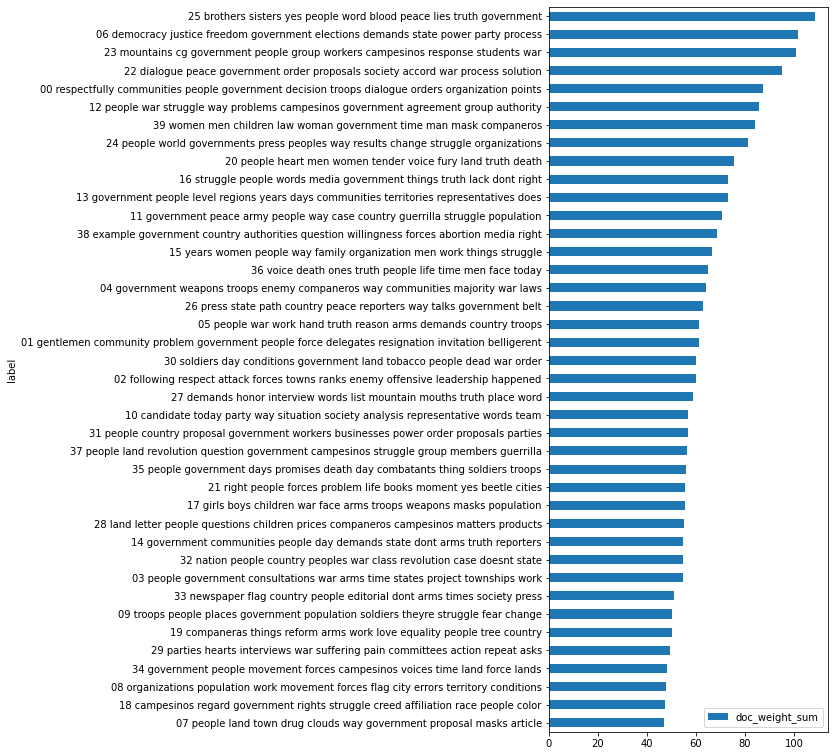

In [46]:
MP.show_topic_bar()

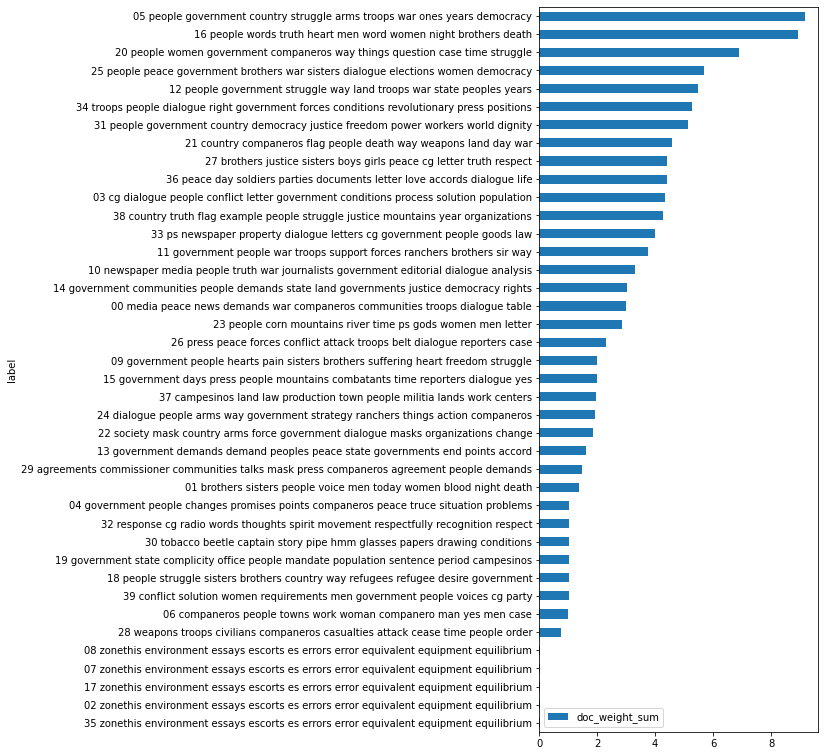

In [47]:
MC.show_topic_bar()